In [8]:
%load_ext autoreload
%autoreload 2
import numpy as N
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import modules.plotmodule as pm
import modules.simulator as sim
from modules.datahandler import getDataHandler
import pandas as pd
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from metpy.plots import ctables
# Weird that you have to do this twice...
%matplotlib notebook
%matplotlib notebook 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Some global parameters
rhoa = 1.0 # kg m^-3
cr = 1000.*N.pi/6.

sampling_area = dis.sensor_area
sampling_width = dis.sensor_width
sampling_length = dis.sensor_length

In [3]:
# Function definitions
def plotDSD(Dl, Dmid, Dr, ND, ax=None):
    """Plots a DSD on a semilog plot"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.bar(Dl, ND, Dr-Dl, 10.**2., align='edge', log=True, color='tan', edgecolor = 'k')
    ax.set_yscale('log')
    ax.set_ylim(10.**2., 10.**8.5)
    ax.set_xlim(0., 9.)
    ax.set_xlabel('D (mm)')
    ax.set_ylabel(r'N(D) $(m^{-4})$')
    
    return ax

def plotVD(Dl, Dmid, Vl, countsMatrix, Vt_fit, ax=None, strongwindflag=False):
    """Plot drop counts in each velocity/diameter bin for a given DSD"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    countsplot = ma.masked_where(countsMatrix <= 0, countsMatrix)

    C = ax.pcolor(Dl, Vl, countsplot, vmin=1, vmax=50, edgecolors='w')
    ax.plot(Dmid, Vt_fit, c='r')
    # ax1.scatter(X[0:10,20:31],Y[0:10,20:31],c='r',marker='x')
    fig.colorbar(C)

    if(strongwindflag):
        ax.text(0.5, 0.5, 'Flagged for strong wind contamination!',
                 horizontalalignment='center',
                 verticalalignment='center', color='y',
                 transform=ax.transAxes)
#     if(plot_strongwindQC):
#         ax1.scatter(X[strongwindmask], Y[strongwindmask], c='r', marker='x', alpha=1.0)
#     if(plot_splashingQC):
#         ax1.scatter(X[splashmask], Y[splashmask], c='w', marker='o', alpha=0.75)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(splashmask,mask=-splashmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_marginQC):
#         ax1.scatter(X[marginmask], Y[marginmask], c='g', marker='x', alpha=0.1)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(marginmask,mask=-marginmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_rainfallspeedQC):
#         ax1.scatter(X[fallspeedmask], Y[fallspeedmask], c='k', marker='x', alpha=0.5)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(fallspeedmask,mask=-fallspeedmask),cmap=cm.gray,alpha=0.1)
#     if(plot_rainonlyQC):
#         ax1.scatter(X[rainonlymask], Y[rainonlymask], c='g', marker='x', alpha=0.5)

    ax.set_xlim(0.0, 9.0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_xlabel('D (mm)')
    ax.set_ylim(0.0, 15.0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_ylabel(r'V$_T$ (m s$^{-1}$)')

In [4]:
D = dis.avg_diameter/1000.
Dl = dis.min_diameter/1000.
Dr = dis.max_diameter/1000.

Dedges = N.append(Dl,Dr[-1])
print Dedges

qr = 1.0 # g kg^-1
N0r = 8.0e6 # M-P value (m^-4)

ND, Ntr, lamdar, alphar = gammaDSD(D, cr, qr, N0=N0r)
print Ntr

ND_sample = samplegammaDSD(Ntr, lamdar, alphar, bins=Dedges)

print ND
print ND_sample

[0.       0.000125 0.00025  0.000375 0.0005   0.000625 0.00075  0.000875
 0.001    0.001125 0.00125  0.0015   0.00175  0.002    0.00225  0.0025
 0.003    0.0035   0.004    0.0045   0.005    0.006    0.007    0.008
 0.009    0.01     0.012    0.014    0.016    0.018    0.02     0.023
 0.026   ]
3572.9753669520087
[6.95528742e+06 5.25733038e+06 3.97388650e+06 3.00376289e+06
 2.27047036e+06 1.71619260e+06 1.29722770e+06 9.80542454e+05
 7.41167880e+05 5.60230539e+05 3.68164629e+05 2.10349963e+05
 1.20182938e+05 6.86662284e+04 3.92322821e+04 1.69431493e+04
 5.53088834e+03 1.80549232e+03 5.89381365e+02 1.92396494e+02
 3.58837884e+01 3.82384074e+00 4.07475315e-01 4.34212992e-02
 4.62705138e-03 1.60955783e-04 1.82771975e-06 2.07545166e-08
 2.35676153e-10 2.67620056e-12 9.92024574e-15 1.20040268e-17]
[6.888e+06 5.328e+06 4.104e+06 3.008e+06 2.184e+06 1.616e+06 1.176e+06
 1.072e+06 8.160e+05 5.200e+05 3.320e+05 2.200e+05 1.400e+05 1.080e+05
 4.800e+04 2.600e+04 8.000e+03 2.000e+03 4.000e+03 0.00

<IPython.core.display.Javascript object>


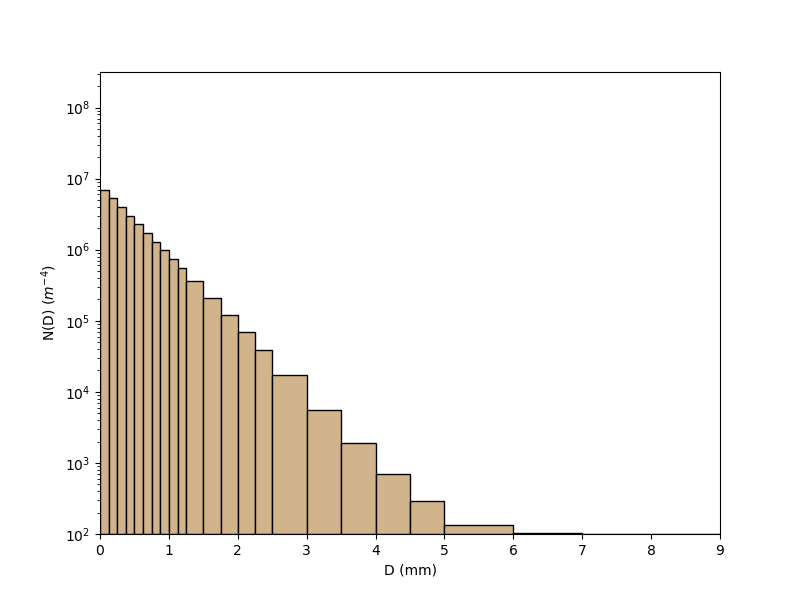

In [9]:
ax = plotDSD(Dl*1000., D*1000., Dr*1000., ND)

Dmax_index =  29
sampling height =  96.49884686506121
sampling volume =  0.5210937730713305
number concentration =  3572.9753669520087
number of particles in sampling volume =  1861
number of particles less than Dmax =  1861
number of particles that fall through sampling area =  403
number of these that are margin fallers =  13
Removing margin fallers!


<IPython.core.display.Javascript object>


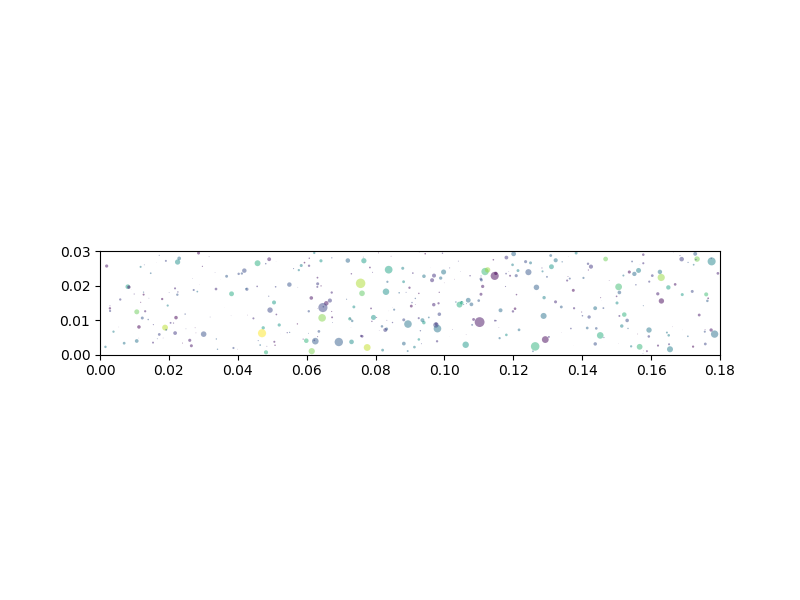

In [10]:
remove_margins = True
Vtr = dis.assignfallspeed(dis.avg_diameter)
sample_dict = create_random_gamma_DSD(Ntr, lamdar, alphar, Vtr, 
                                      sampling_length, sampling_width, Dl, D, Dr, verbose=True, 
                                      remove_margins=remove_margins)
positions = sample_dict['positions']
diameters = sample_dict['diameters']
velocities = sample_dict['velocities']
ND_sample = sample_dict['ND']
margin_mask = sample_dict['margin_mask']

positions = positions.T
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
circles(positions[0], positions[1], diameters/2., c=positions[2], alpha=0.5)
if not remove_margins:
    circles(positions[0][margin_mask], positions[1][margin_mask], diameters[margin_mask], c='r', alpha=1.0)
#ax.scatter(positions[0], positions[1], c=positions[2], alpha=0.5, s=diameters*1000.)
ax.set_xlim(0.0, sampling_length)
ax.set_ylim(0.0, sampling_width)
ax.set_aspect('equal')

29


<IPython.core.display.Javascript object>


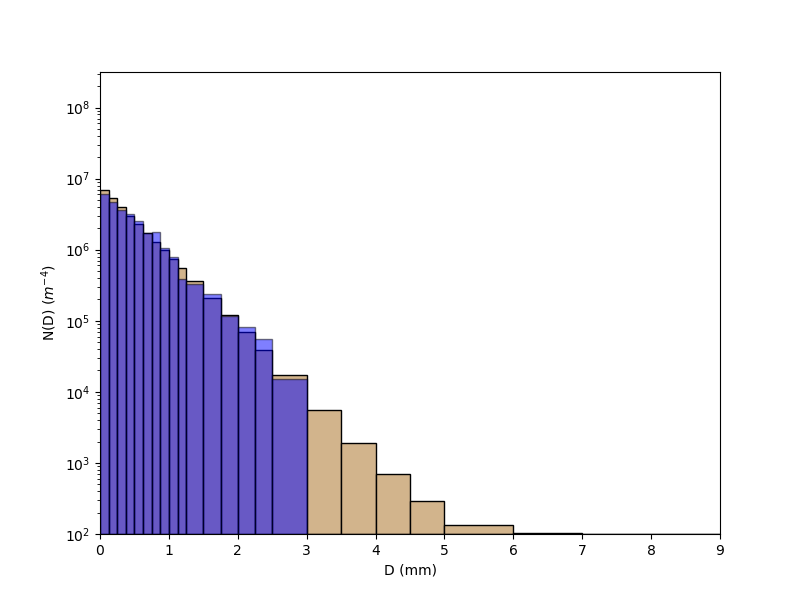

<BarContainer object of 30 artists>

In [11]:
# Plot ND along with sampled ND
Dmax = 20.
Dmax_index = N.searchsorted(Dr, Dmax/1000.)
print Dmax_index
ax = plotDSD(Dl*1000., D*1000., Dr*1000., ND)
ax.bar(Dl[:Dmax_index+1]*1000., ND_sample, (Dr-Dl)[:Dmax_index+1]*1000., 10.**2., align='edge', log=True, color='b', edgecolor = 'k', alpha=0.5)


In [ ]:
# Compute gamma distribution as a function of total number concentration and the PDF for the middle of each bin
shape = alphar+1
scale = 1./lamdar
x = D
s = Ntr*gamma.pdf(x, shape, scale=scale)

# Now sample the gamma distribution
s_sample = gamma.rvs(shape, scale=scale, size=int(Ntr))
# Bin up the samples into the Parsivel bins
s_binned,_ = N.histogram(s_sample, bins=Dedges)

# For plotting need to divide by the bin widths, since above we get number of drops/unit volume in each bin
# So this gives us number of drops/unit volume/diameter interval
s_sample_plot = s_binned/(Dr-Dl)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, s)
ax.bar(Dl, s_sample_plot, Dr - Dl, 10**2., align='edge', log=True, color='tan', edgecolor='k')
ax.set_yscale('log')
ax.set_ylim(10.**2.0, 10.**8.5)
ax.set_xlim(0.0,0.009)

# s_hist,_ = N.histogram(s, bins=50, density=True)
# print s_hist
# print s_hist.sum()
# count, bins, ignored = plt.hist(s, 50, normed=True)

In [12]:
# Read in a COMMAS file. Start with one time and move the grid relative to a fixed location
modelname = 'COMMAS'
dirname = '/Volumes/scr_fast/Projects/VORTEX2/V2_disdrometer/simulations/COMMAS/060509/1km/'
runname = 'jun05ZVDH3MCCN1imlt2_nz61'
model_dt = 120.
model_times = N.arange(9240., 10800.+model_dt, model_dt)
multitime = True
fixed_time = False
microphys = 'ZVD'
dh = getDataHandler(modelname, dirname, model_times, microphys, multitime=multitime)
dh.setRun(runname, 0)
xc, yc, zc, zc1d, xe, ye, ze, ze1d, bgmap = dh.loadGrid()
dx = xc[0,0,1]-xc[0,0,0]
dy = yc[0,1,0]-yc[0,0,0]
print dx, dy

1000.0 1000.0


In [13]:
dh.loadTimes()
time = model_times[0]
timestring = dh.setTime(time)
dp_data, consts = dh.loadMicrophysics()
# Extract the lowest model level and store in dp_data_2D
dp_data_2D = {}
for key, dat in dp_data.iteritems():
    dp_data_2D[key] = dat[:,:,0]
dp_data_plot = {}
for key, dat in dp_data_2D.iteritems():
    dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()


Reading microphysics information for ZVDH scheme.


/Users/dawson29/pyPIPS/modules/commasmodule.py:439: RuntimeWarning: invalid value encountered in divide
  micro['rhog'] = micro['qg'] * micro['rhoa'] / volg
/Users/dawson29/pyPIPS/modules/commasmodule.py:444: RuntimeWarning: invalid value encountered in divide
  micro['rhoh'] = micro['qh'] * micro['rhoa'] / volh


Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


model_times_rel =  [-360. -240. -120.    0.  120.  240.  360.  480.  600.  720.  840.  960.
 1080. 1200.]
sampling_times =  [-300. -240. -180. -120.  -60.    0.   60.  120.  180.  240.  300.  360.
  420.  480.  540.  600.  660.  720.  780.  840.  900.  960. 1020. 1080.
 1140. 1200.]
combined_times =  [-360. -300. -240. -180. -120.  -60.    0.   60.  120.  180.  240.  300.
  360.  420.  480.  540.  600.  660.  720.  780.  840.  900.  960. 1020.
 1080. 1140. 1200.]
dis_xlocs =  [45100. 44500. 43900. 43300. 42700. 42100. 41500. 40900. 40300. 39700.
 39100. 38500. 37900. 37300. 36700. 36100. 35500. 34900. 34300. 33700.
 33100. 32500. 31900. 31300. 30700. 30100. 29500.]
dis_ylocs =  [56780. 56900. 57020. 57140. 57260. 57380. 57500. 57620. 57740. 57860.
 57980. 58100. 58220. 58340. 58460. 58580. 58700. 58820. 58940. 59060.
 59180. 59300. 59420. 59540. 59660. 59780. 59900.]
xlocs =  [45100.0, 45000.0, 45000.0, 44500.0, 44000.0, 44000.0, 43900.0, 43300.0, 43000.0, 43000.0, 42700.0, 42100.0, 42

<IPython.core.display.Javascript object>


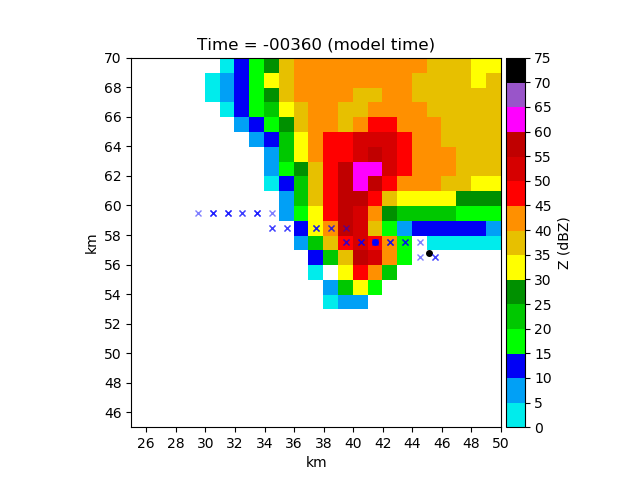

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  45100.0 56780.0


<IPython.core.display.Javascript object>


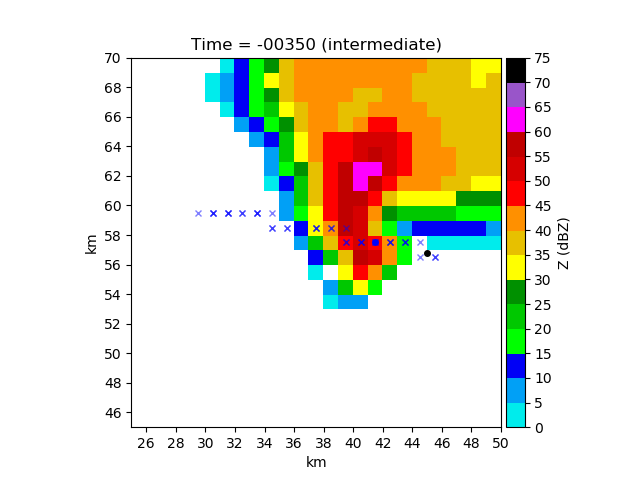

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  45000.0 56800.0


<IPython.core.display.Javascript object>


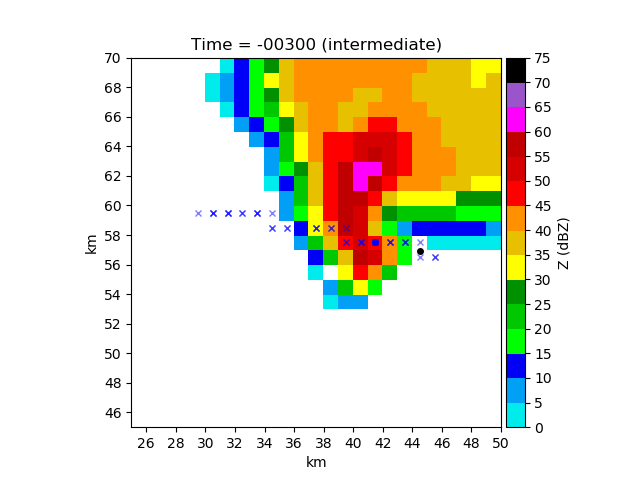

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  44500.0 56900.0


<IPython.core.display.Javascript object>


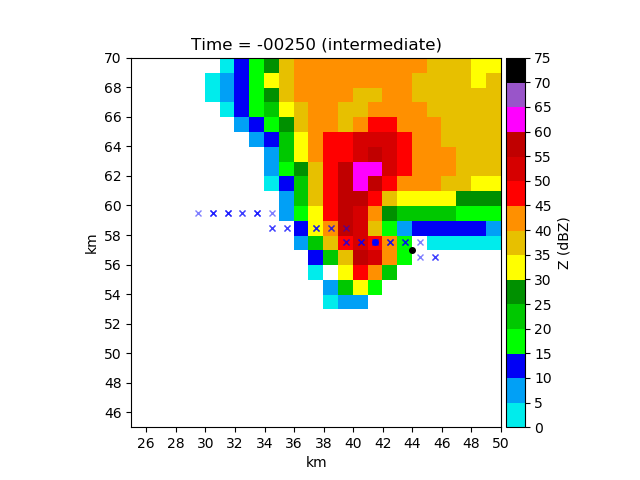

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  44000.0 57000.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


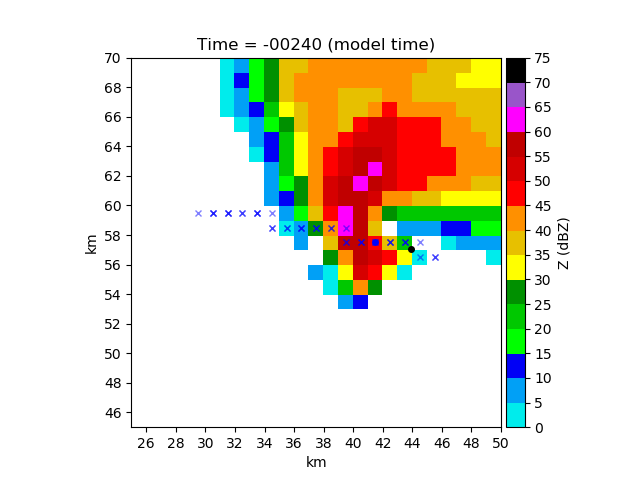

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  43900.0 57020.0


<IPython.core.display.Javascript object>


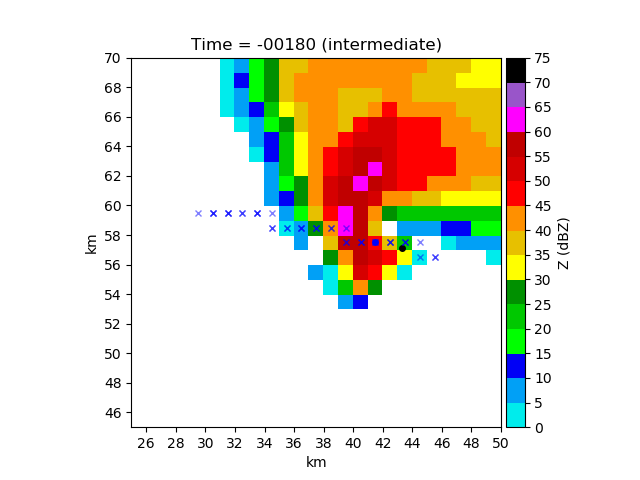

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  43300.0 57140.0


<IPython.core.display.Javascript object>


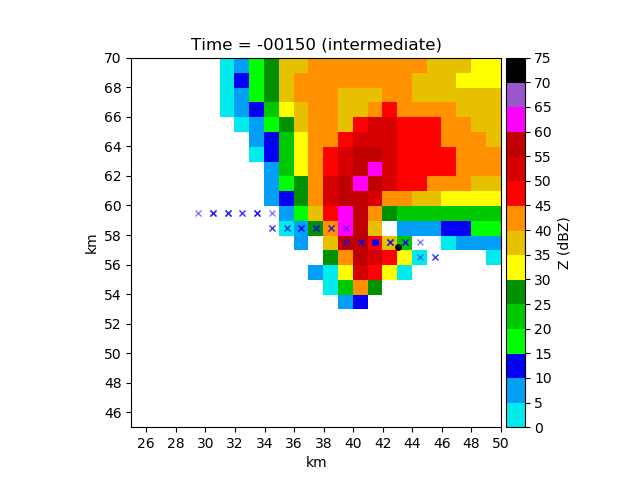

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  43000.0 57200.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


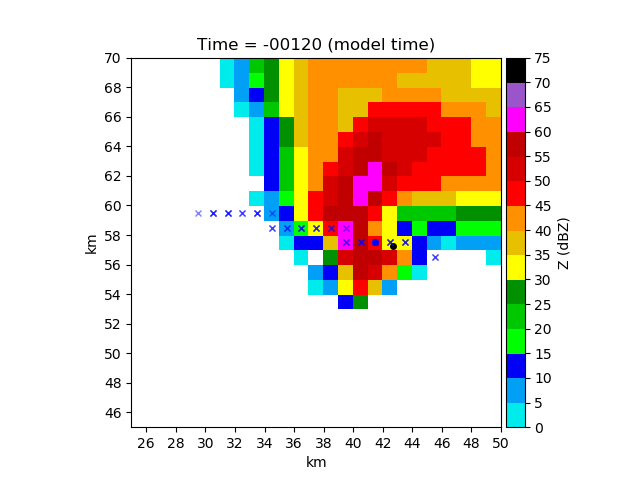

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  42700.0 57260.0


<IPython.core.display.Javascript object>


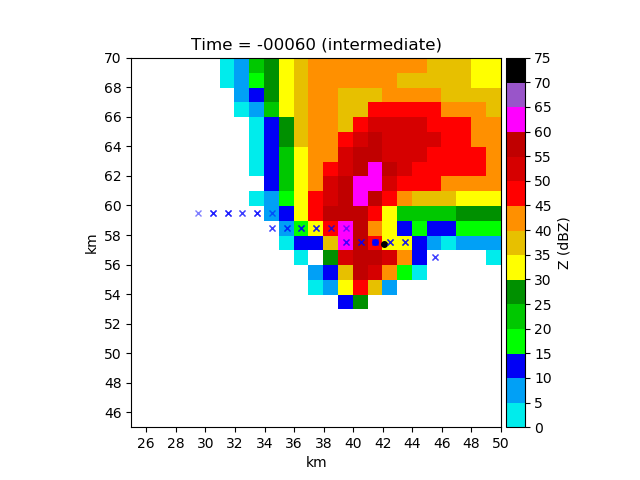

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  42100.0 57380.0


<IPython.core.display.Javascript object>

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  42000.0 57400.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


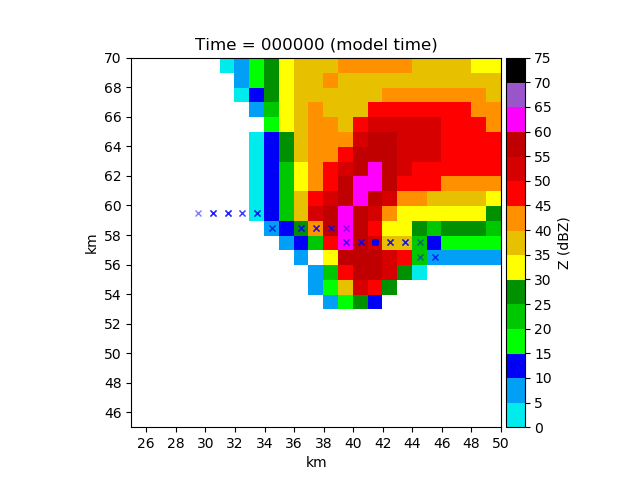

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  41500.0 57500.0


<IPython.core.display.Javascript object>


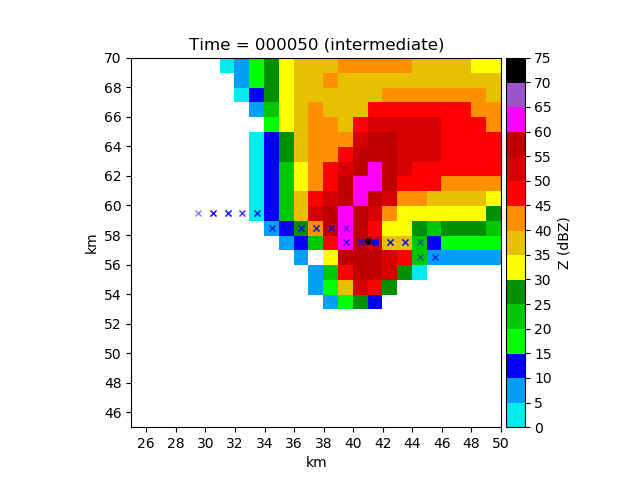

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  41000.0 57600.0


<IPython.core.display.Javascript object>


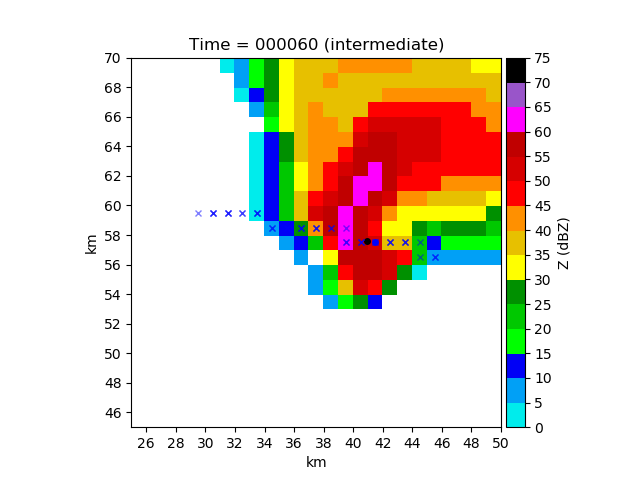

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  40900.0 57620.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


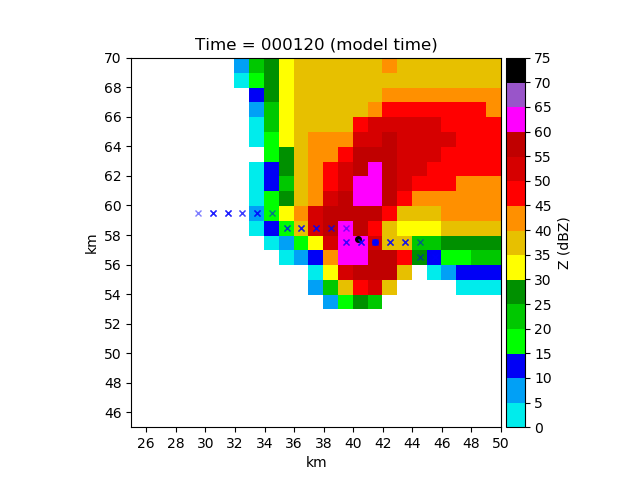

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  40300.0 57740.0


<IPython.core.display.Javascript object>


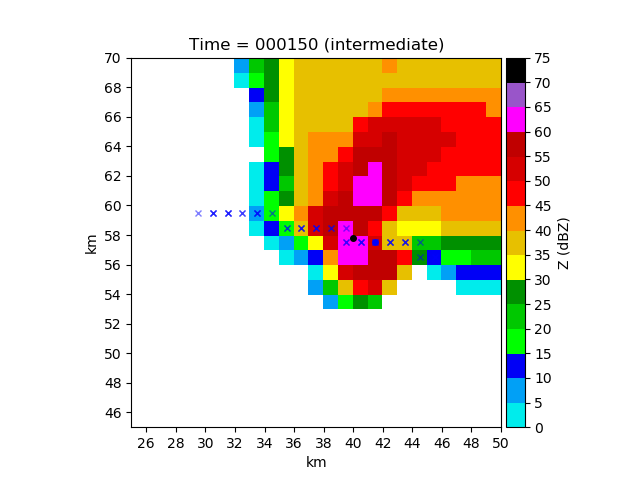

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  40000.0 57800.0


<IPython.core.display.Javascript object>

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  39700.0 57860.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


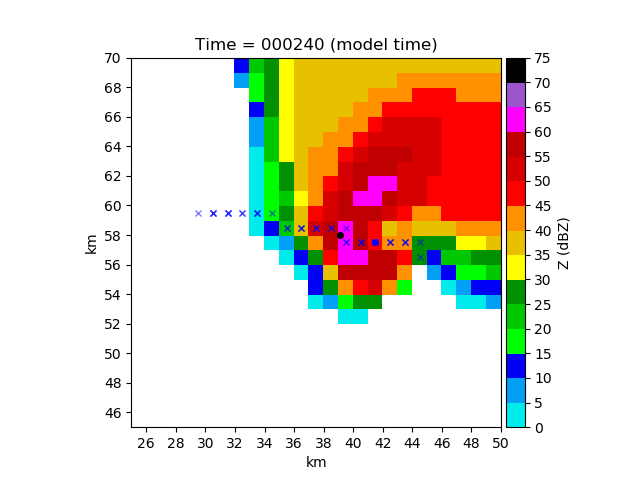

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  39100.0 57980.0


<IPython.core.display.Javascript object>


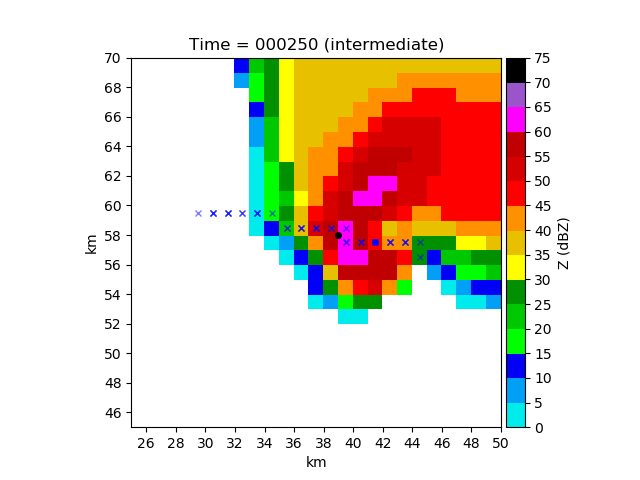

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  39000.0 58000.0


<IPython.core.display.Javascript object>

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  38500.0 58100.0


<IPython.core.display.Javascript object>

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  38000.0 58200.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  37900.0 58220.0


<IPython.core.display.Javascript object>


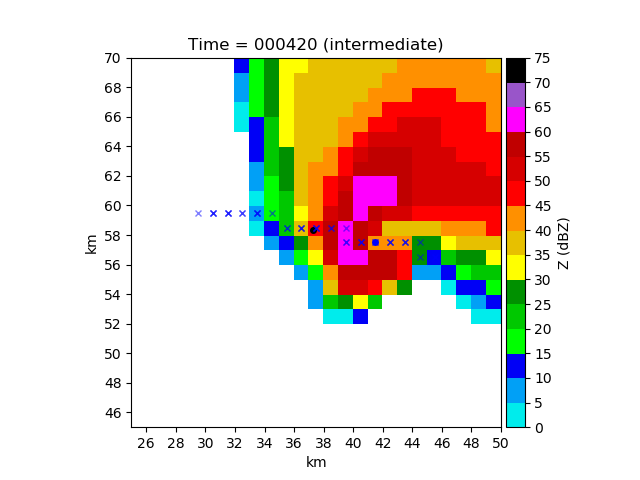

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  37300.0 58340.0


<IPython.core.display.Javascript object>


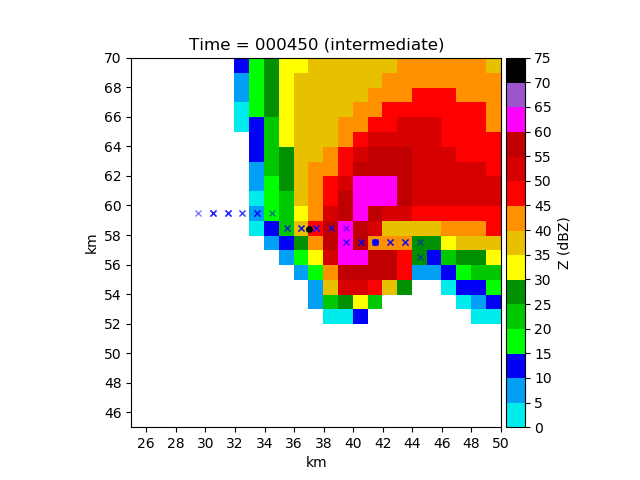

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  37000.0 58400.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


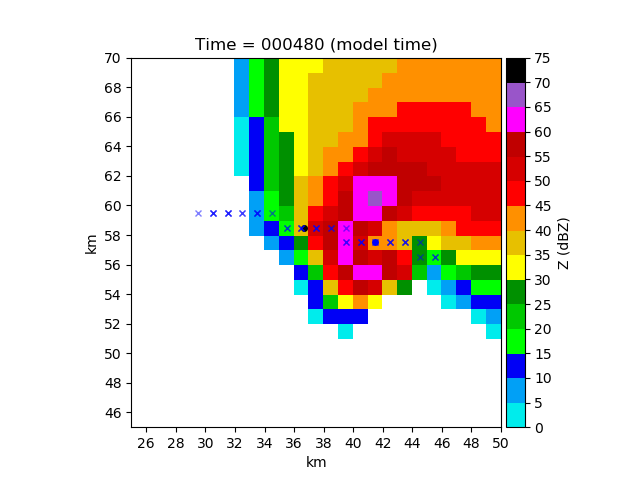

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  36700.0 58460.0


<IPython.core.display.Javascript object>


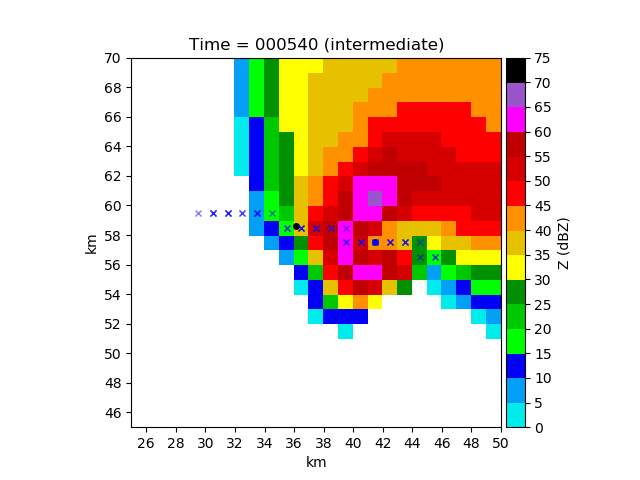

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  36100.0 58580.0


<IPython.core.display.Javascript object>


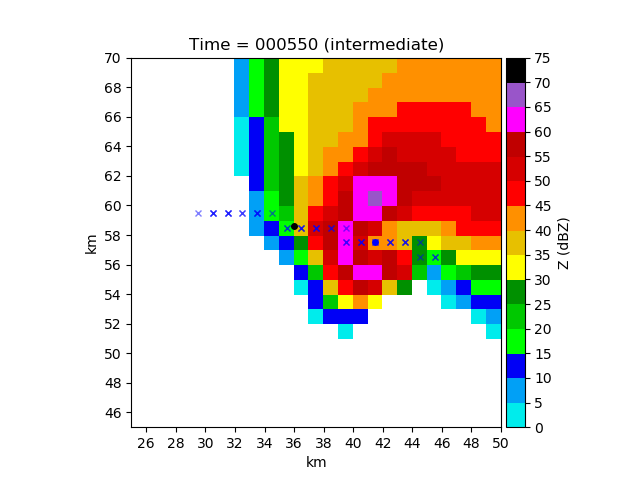

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  36000.0 58600.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


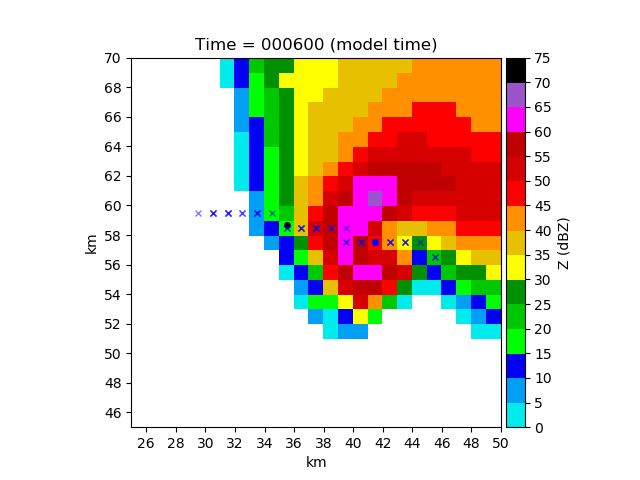

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  35500.0 58700.0


<IPython.core.display.Javascript object>


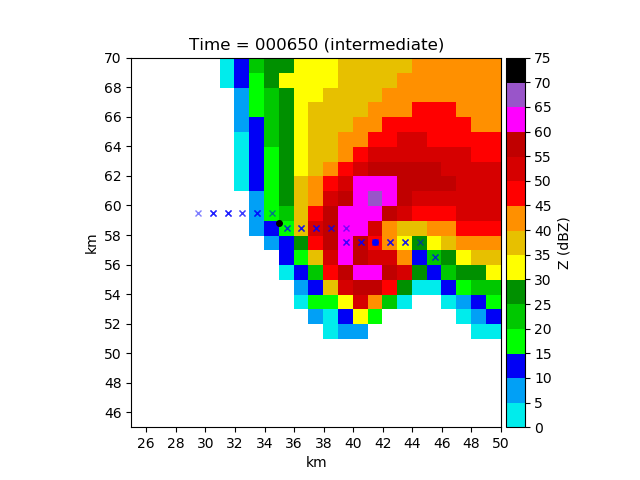

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  35000.0 58800.0


<IPython.core.display.Javascript object>


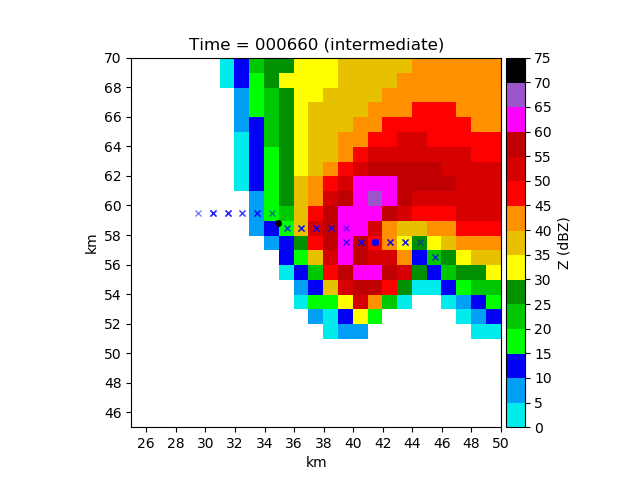

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  34900.0 58820.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


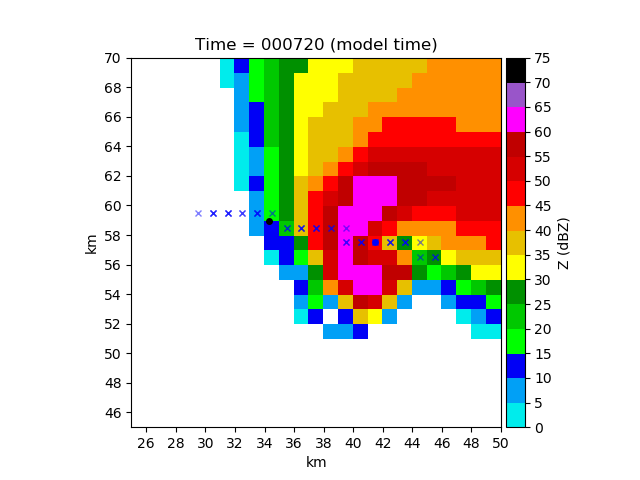

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  34300.0 58940.0


<IPython.core.display.Javascript object>


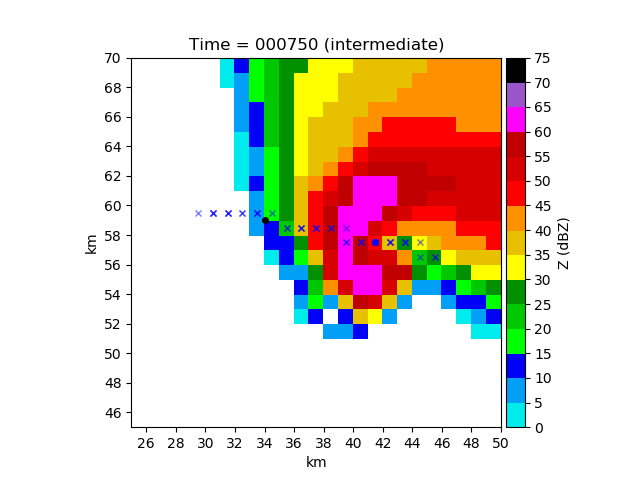

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  34000.0 59000.0


<IPython.core.display.Javascript object>


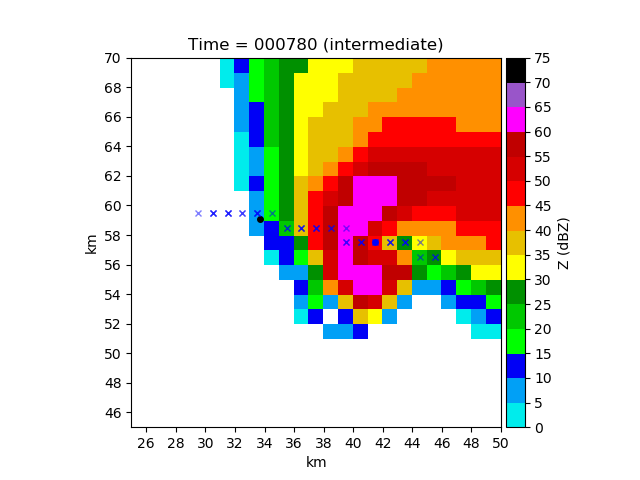

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  33700.0 59060.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


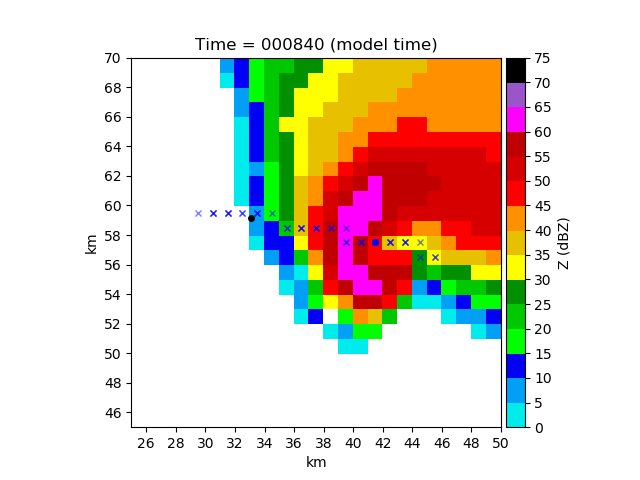

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  33100.0 59180.0


<IPython.core.display.Javascript object>


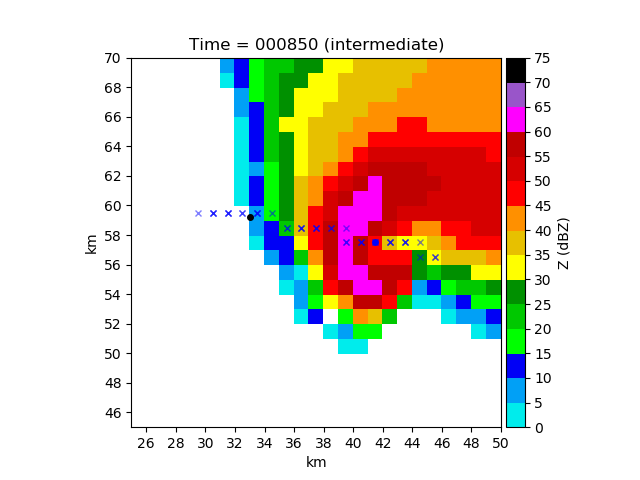

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  33000.0 59200.0


<IPython.core.display.Javascript object>


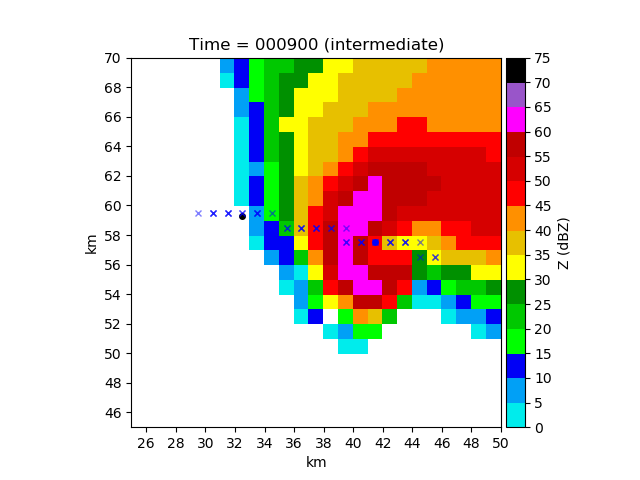

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  32500.0 59300.0


<IPython.core.display.Javascript object>


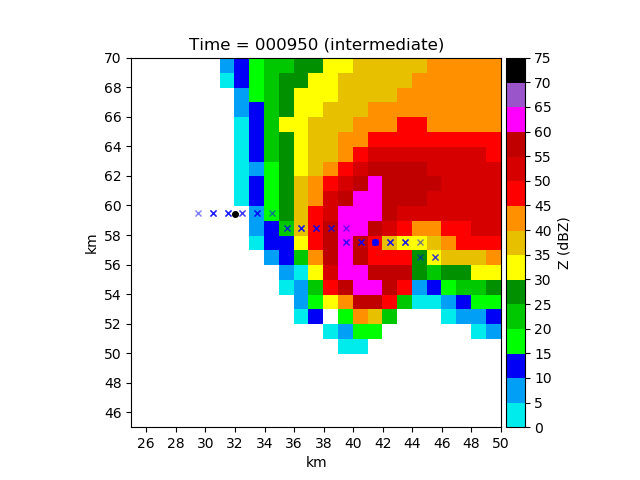

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  32000.0 59400.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


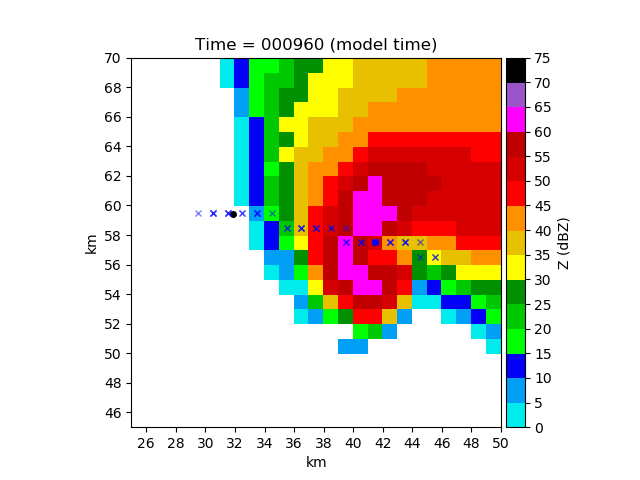

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  31900.0 59420.0


<IPython.core.display.Javascript object>


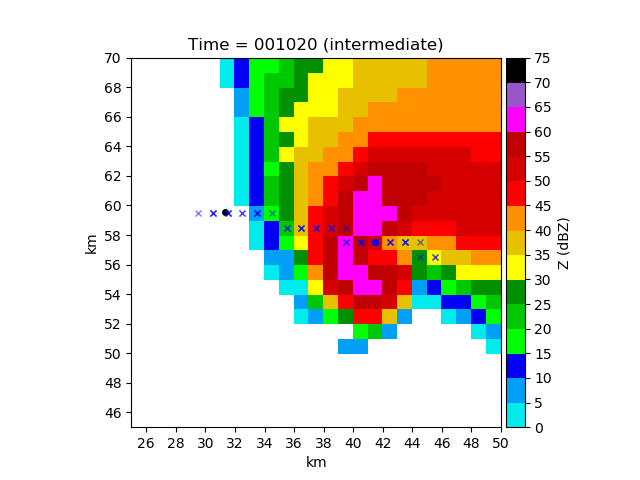

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  31300.0 59540.0


<IPython.core.display.Javascript object>


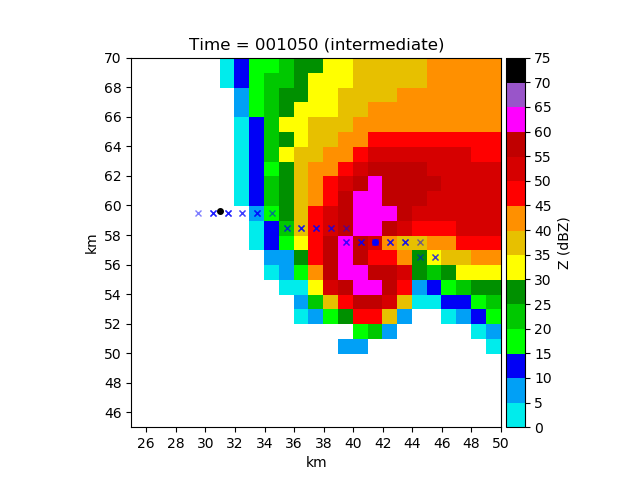

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  31000.0 59600.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


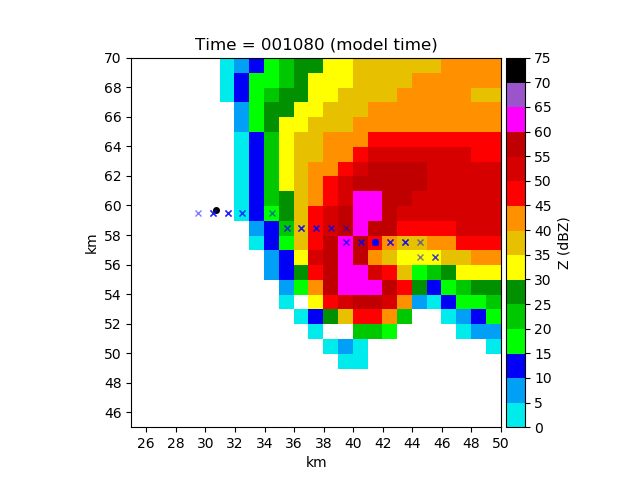

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  30700.0 59660.0


<IPython.core.display.Javascript object>


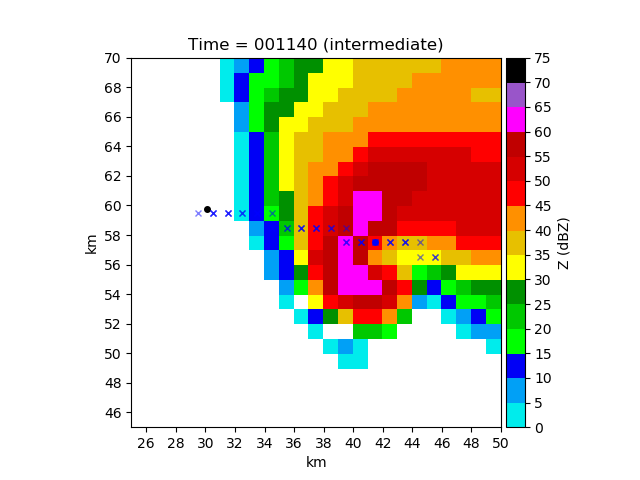

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  30100.0 59780.0


<IPython.core.display.Javascript object>


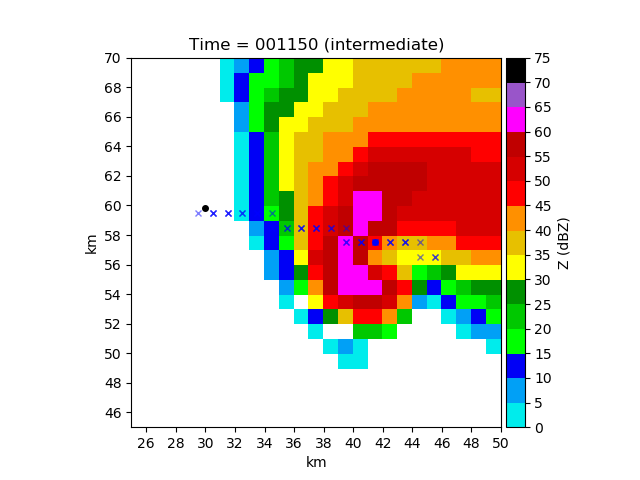

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  30000.0 59800.0
Reading microphysics information for ZVDH scheme.
Rain is gamma-diameter.
Found ZR array! Computed shape parameter for rain.
Did not find ZS array! Assuming 2-moment with constant shape parameter.
Found ZG array! Computed shape parameter for grpl.
Found ZH array! Computed shape parameter for hail.


<IPython.core.display.Javascript object>


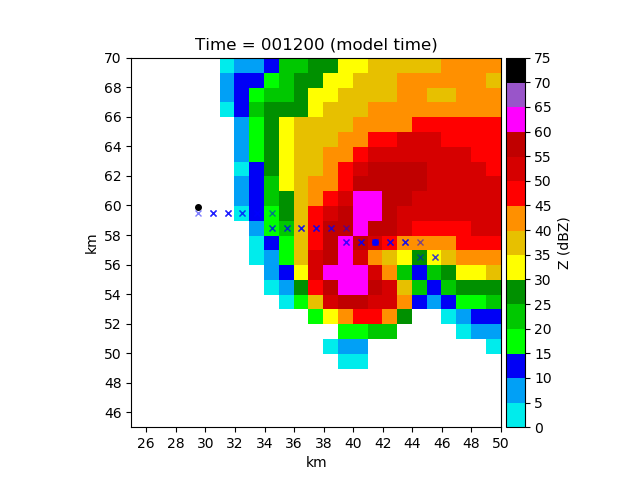

[25000.0, 50000.0] [45000.0, 70000.0]
2000.0 2000.0
x, y =  29500.0 59900.0


In [78]:
# Ok, we are going to try to use the shapely library to figure out the intersections of the disdrometer "path"
# through the horizontally moving grid with the grid lines. We also want to allow for time to pass discretely
# between model history dumps. So, we have a 3D grid that the disdrometer
# moves through: 2D in space (x and y), and 1D in time. Thus, we first need to construct a collection of planes
# that represent the 3D grid boundaries.
# EDIT: for now just testing for 2D case
# Assumes a regular grid for now
# Based on https://stackoverflow.com/questions/45200428/how-to-find-intersection-of-a-line-with-a-mesh/45203700
from shapely.geometry import MultiLineString, LineString
from matplotlib.collections import LineCollection

xe1d = xe[0, 0, :]
ye1d = ye[0, :, 0]


xcplot = xc[0, :, :]
ycplot = yc[0, :, :]
xeplot = xe[0, :, :]
yeplot = ye[0, :, :]
xcorplot, ycorplot = pm.computecorners(xeplot, yeplot)

lines=[]
for x in xe1d:
    lines.append(((x, ye1d[0]), (x, ye1d[-1])))

for y in ye1d:
    lines.append(((xe1d[0], y), (xe1d[-1], y)))
    
grid = MultiLineString(lines)

# Reference time
reference_time = 9600.
# Location of fixed disdrometer at the reference time (m)
dis_x = 41500.
dis_y = 57500.
# Model times relative to reference time
model_times_rel = N.array(model_times - reference_time)
print "model_times_rel = ", model_times_rel
if model_times_rel.size == 1:
    fixed_time = True
# Movement of grid (m/s)
umove = 10.0
vmove = -2.0
# Sampling interval of the virtual disdrometer
sampling_interval = 60.
# Seconds before reference time to start the sampling
sampling_start = -300.
# Seconds after the reference time to stop the sampling
sampling_stop = 1200. 

# Calculate the range of times and the x and y locations at the end of each sampling window of the virtual disdrometer
sampling_times = N.arange(sampling_start, sampling_stop+sampling_interval, sampling_interval)
print "sampling_times = ", sampling_times
# Combine the sampling times and model times into a single array
combined_times = N.concatenate((sampling_times, model_times_rel))
combined_times = N.unique(combined_times)
print "combined_times = ", combined_times
dis_xlocs = dis_x - umove*combined_times
dis_ylocs = dis_y - vmove*combined_times
print "dis_xlocs = ", dis_xlocs
print "dis_ylocs = ", dis_ylocs

line = LineString(N.c_[dis_xlocs, dis_ylocs])

# fig = plt.figure(figsize=(8,2))
# ax = fig.add_subplot(111)

all_times = []
xlocs = []
ylocs = []
ilocs = []
jlocs = []

for i, segment in enumerate(line.difference(grid)):
    x, y = segment.xy
#     print "i = ", i
#     print "x = ", N.array(x)
#     print "y = ", N.array(y)
#     plt.plot(x, y)
#     plt.text(N.mean(x), N.mean(y), str(i))
    
    # compute times of each crossing (relative to reference time)
    t = (dis_x - N.array(x))/umove
#     print "t = ", t
    xlocs = xlocs + list(x)
    ylocs = ylocs + list(y)
    all_times = all_times + list(t)

# lc = LineCollection(lines, color="gray", lw=1, alpha=0.5)
# ax.add_collection(lc)
# ax.set_aspect('equal')

print "xlocs = ", xlocs
print "ylocs = ", ylocs
print "all_times = ", all_times

xlocs = pd.unique(xlocs)
ylocs = pd.unique(ylocs)
all_times = pd.unique(all_times)

print "xlocs = ", xlocs
print "ylocs = ", ylocs
print "all_times = ", all_times

# Calculate the fractional i and j indices relative to grid edges corresponding to the x, y locations
ilocs = (xlocs-xeplot[0,0])/dx
jlocs = (ylocs-yeplot[0,0])/dy
print "ilocs = ", ilocs
print "jlocs = ", jlocs
# Calculate the fractional time indices corresponding to each point
if not fixed_time:
    tlocs = (all_times-model_times_rel[0])/model_dt
    tlocs = N.where(tlocs < 0.0, 0.0, tlocs)
    print "tlocs = ", tlocs
# Find the indices of the edges of the grid boxes that the disdrometer traverses during the sampling time
igllocs = ilocs.astype(int)
jgllocs = jlocs.astype(int)
print "igllocs = ", igllocs
print "jgllocs = ", jgllocs
# The -1 below is because we want to identify the right edges with the next lowest grid centers
igrlocs = N.ceil(ilocs).astype(int)-1
jgrlocs = N.ceil(jlocs).astype(int)-1
print "igrlocs = ", igrlocs
print "jgrlocs = ", jgrlocs
if not fixed_time:
    tgblocs = tlocs.astype(int)
    print "tgblocs = ", tgblocs

# The grid edge indices we want to use for calculating the sampling depend on the grid motion
if umove > 0 and vmove > 0:
    locs = [jgrlocs, igrlocs]
elif umove < 0 and vmove > 0:
    locs = [jgrlocs, igllocs]
elif umove < 0 and vmove < 0:
    locs = [jgllocs, igllocs]
else:
    locs = [jgllocs, igrlocs]

# For plotting we want the indices of the west and south edges
plocs = [jgllocs, igllocs]
    
dp_data_plot_list = []
Zmodplot_list = []
time = None
for t, tloc in enumerate(tgblocs):
    if(model_times[tloc] != time):
        time = model_times[tloc]
        timestring = dh.setTime(time)
        dp_data, consts = dh.loadMicrophysics()
        # Extract the lowest model level and store in dp_data_2D
        dp_data_2D = {}
        for key, dat in dp_data.iteritems():
            dp_data_2D[key] = dat[:,:,0]
        dp_data_plot = {}
        for key, dat in dp_data_2D.iteritems():
            dp_data_plot[key] = dat.swapaxes(0, 1).squeeze()
        dp_data_plot_list.append(dp_data_plot)

        Zmod = dh.loadModelReflectivity()
        Zmodplot = Zmod[:, :, 0].T
        Zmodplot_list.append(Zmodplot)
    else:
        dp_data_plot = dp_data_plot_list[-1]
        dp_data_plot_list.append(dp_data_plot)
        Zmodplot = Zmodplot_list[-1]
        Zmodplot_list.append(Zmodplot)
    
    # qrplot = dp_data_2D['qr'].T*1000.
    
    fig = None
    ax = None
    ptype = 2
    xlim = [25000.0, 50000.0]
    ylim = [45000.0, 70000.0]
    clevels = N.arange(0., 85., 5.)
    norm, cmap = ctables.registry.get_with_steps('NWSReflectivity', 0., 5.)
    clabel = 'Z (dBZ)'
    cformat = None
    ovrmap = False
    gis_info = None
    numovr = 0
    axesticks = [2000., 2000.]
    
    fig, ax = pm.plotsingle(fig, ax, ptype, xcplot, ycplot, xcorplot, ycorplot, xlim, ylim, Zmodplot, clevels, cmap, norm,
                        clevels, clabel, cformat, ovrmap, gis_info, numovr, None, None, None, None, None,
                        axesticks)

    # Plot the locations of the disdrometer at each time in the sampling period
    #ax.plot(dis_xlocs, dis_ylocs, 'ko', ms=2)
    print "x, y = ", xlocs[t], ylocs[t]
    ax.plot(xlocs[t], ylocs[t], 'ko', ms=4)
    ax.plot(dis_x, dis_y, 'bo', ms=4)
    ax.plot(xcplot[plocs], ycplot[plocs], 'bx', ms=5, alpha=0.5)
    
    if(all_times[t] == model_times_rel[tloc]):
        titlestring = 'Time = %06d' % all_times[t] + ' (model time)'
    else:
        titlestring = 'Time = %06d' % all_times[t] + ' (intermediate)'
    
    ax.set_title(titlestring)
    


In [83]:
sample_indices = N.searchsorted(all_times, sampling_times)
print "sampling_times = ", sampling_times
print "all_times = ", all_times
print "sample_indices = ", sample_indices

# dt = N.zeros_like(all_times)
# dt[0] = 0.0
dt = all_times[1:]-all_times[:-1]
print "dt = ", dt

sample_indices = N.searchsorted(all_times, sampling_times)
print N.size(sample_indices), N.size(sampling_times)
t = 0
for s, sample_index in enumerate(sample_indices[:-1]):
    sample_index_end = sample_indices[s+1]
    print "s, sample_index, sample_index_end = ", s, sample_index, sample_index_end
    current_sample_indices = slice(sample_index, sample_index_end, None)
    print "sample time (beginning) = ", sampling_times[s]
    print "sample time (end) = ", sampling_times[s+1]
    print "delta_t's for this interval = ", dt[current_sample_indices]

print "locs = ", locs 
print "xcplot[locs] = ", xcplot[locs]

print "locs (t=0) = ", (jgllocs[0], igllocs[0])
print "xcplot[locs] (t=0) = ",xcplot[(jgllocs[0], igllocs[0])]

sampling_times =  [-300. -240. -180. -120.  -60.    0.   60.  120.  180.  240.  300.  360.
  420.  480.  540.  600.  660.  720.  780.  840.  900.  960. 1020. 1080.
 1140. 1200.]
all_times =  [-360. -350. -300. -250. -240. -180. -150. -120.  -60.  -50.    0.   50.
   60.  120.  150.  180.  240.  250.  300.  350.  360.  420.  450.  480.
  540.  550.  600.  650.  660.  720.  750.  780.  840.  850.  900.  950.
  960. 1020. 1050. 1080. 1140. 1150. 1200.]
sample_indices =  [ 2  4  5  7  8 10 12 13 15 16 18 20 21 23 24 26 28 29 31 32 34 36 37 39
 40 42]
dt =  [10. 50. 50. 10. 60. 30. 30. 60. 10. 50. 50. 10. 60. 30. 30. 60. 10. 50.
 50. 10. 60. 30. 30. 60. 10. 50. 50. 10. 60. 30. 30. 60. 10. 50. 50. 10.
 60. 30. 30. 60. 10. 50.]
26 26
s, sample_index, sample_index_end =  0 2 4
sample time (beginning) =  -300.0
sample time (end) =  -240.0
delta_t's for this interval =  [50. 10.]
s, sample_index, sample_index_end =  1 4 5
sample time (beginning) =  -240.0
sample time (end) =  -180.0
delta_t's fo

loc =  (56, 45)
loc =  (56, 44)
loc =  (56, 44)
loc =  (57, 43)
loc =  (57, 43)
loc =  (57, 43)
loc =  (57, 42)
loc =  (57, 42)
loc =  (57, 42)
loc =  (57, 41)
loc =  (57, 41)
loc =  (57, 40)
loc =  (57, 40)
loc =  (57, 40)
loc =  (57, 39)
loc =  (57, 39)
loc =  (57, 39)
loc =  (58, 38)
loc =  (58, 38)
loc =  (58, 37)
loc =  (58, 37)
loc =  (58, 37)
loc =  (58, 36)
loc =  (58, 36)
loc =  (58, 36)
loc =  (58, 35)
loc =  (58, 35)
loc =  (58, 34)
loc =  (58, 34)
loc =  (58, 34)
loc =  (59, 33)
loc =  (59, 33)
loc =  (59, 33)
loc =  (59, 32)
loc =  (59, 32)
loc =  (59, 31)
loc =  (59, 31)
loc =  (59, 31)
loc =  (59, 30)
loc =  (59, 30)
loc =  (59, 30)
loc =  (59, 29)
loc =  (59, 29)
rhoa =  [0.9644962  0.96479666 0.96479666 0.9652017  0.9645822  0.9645822
 0.96724355 0.9662874  0.9662874  0.9690778  0.96942735 0.9698181
 0.9698181  0.971036   0.97049206 0.97049206 0.97269446 0.9720607
 0.9720607  0.97132844 0.97169256 0.97169256 0.9710759  0.9713416
 0.9713416  0.9708583  0.97099864 0.9705

<IPython.core.display.Javascript object>


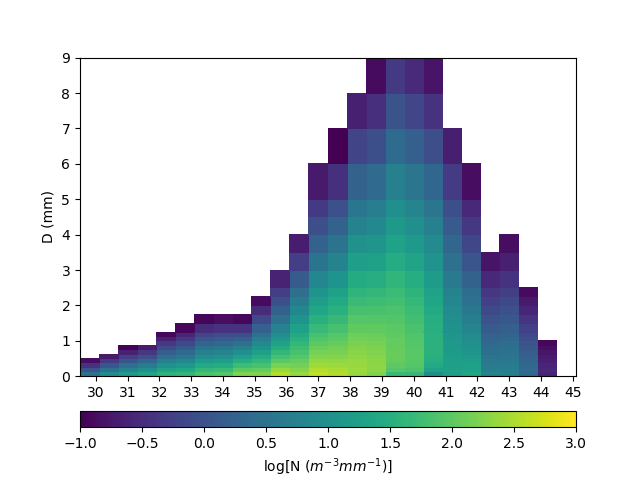

In [85]:
# Now find the values of the various DSD parameters at each disdrometer location
# We can use map_coordinates since we are dealing with a rectilinear non-stretched grid in the horizontal
# from scipy.ndimage import map_coordinates
# coords = N.array([dis_ilocs, dis_jlocs])
# # order=0 means nearest-neighbor interpolation
# dis_Zmod = map_coordinates(Zmodplot.T, coords, order=0)
# dis_rhoa = map_coordinates(dp_data_2D['rhoa'], coords, order=0)
# dis_qr = map_coordinates(dp_data_2D['qr'], coords, order=0)
# dis_ntr = map_coordinates(dp_data_2D['ntr'], coords, order=0)
# dis_alphar = map_coordinates(dp_data_2D['alphar'], coords, order=0)



# Loop through all the times and compute the binned model DSD for each

rhoa = []
qr = []
ntr = []
alphar = []
for t, dp_data_plot in enumerate(dp_data_plot_list):
    loc = (locs[0][t], locs[1][t])
#     print "loc = ", loc
    rhoa.append(dp_data_plot['rhoa'][loc])
    qr.append(dp_data_plot['qr'][loc])
    ntr.append(dp_data_plot['ntr'][loc])
    alphar.append(dp_data_plot['alphar'][loc])
    
rhoa =  N.array(rhoa)
qr = N.array(qr)
ntr = N.array(ntr)
alphar = N.array(alphar)

# print "rhoa = ", rhoa, rhoa.shape
# print "qr = ", qr
# print "ntr = ", ntr
# print "alphar = ", alphar

N0r, _ = dsd.cal_N0(rhoa, qr, ntr, cr, alphar)
lamdar = dsd.cal_lamda(rhoa, qr, ntr, cr, alphar)
Nc_bin_tmp = N.empty((N.size(N0r), N.size(D)))
Nc_bin = N.zeros((N.size(N.array(sampling_times)), N.size(D)))

for index, _ in N.ndenumerate(N0r):
    Nc_bin_tmp[index, :] = 1.e-3*N0r[index]*(D)**alphar[index]*N.exp(-lamdar[index]*(D))
Nc_bin_tmp = N.ma.masked_invalid(Nc_bin_tmp)

# Now loop through and "resample" the number concentrations as weighted averages 
# for the case that the disdrometer crosses a grid edge or the model DSD changes during the sampling interval.

# Special treatment for first sampling time. Just assume DSD valid at that time was constant for the previous 
# sampling interval

sample_indices = N.searchsorted(all_times, sampling_times)
Nc_bin[0, :] = Nc_bin_tmp[sample_indices[0], :]
for s, sample_index in enumerate(sample_indices[:-1]):
    sample_index_end = sample_indices[s+1]
    current_sample_indices = slice(sample_index, sample_index_end, None)
    
    Nc_bin[s+1, :] = N.sum(Nc_bin_tmp[current_sample_indices, :]*dt[current_sample_indices, None], axis = 0)/sampling_interval
#     print "s = ", s
#     print "sample time (beginning) = ", sampling_times[s]
#     print "sample time (end) = ", sampling_times[s+1]
    #print "Nc_bin_tmp = ", Nc_bin_tmp[current_sample_indices, :], dt[current_sample_indices]
    #print "Nc_bin = ", Nc_bin[s+1, :]
    
logNc_bin = N.log10(Nc_bin)
logNc_bin = N.ma.masked_where(logNc_bin <= -1.0,logNc_bin)

fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
C = ax.pcolor(dis_xlocs/1000., Dl*1000., logNc_bin.T, vmin=-1.0, vmax=3.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
#ax.set_xlim(30.0, 50.0)
ax.set_ylim(0.0, 9.0)
ax.set_ylabel('D (mm)')
cax = divider.append_axes("bottom",size="5%",pad=0.35)
cb = fig.colorbar(C,cax=cax,orientation='horizontal')
cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')

plt.savefig('raw_modelDSD.png',dpi=300)

s =  0
sample time (beginning) =  -300.0
sample time (end) =  -240.0
s =  1
sample time (beginning) =  -240.0
sample time (end) =  -180.0
s =  2
sample time (beginning) =  -180.0
sample time (end) =  -120.0
s =  3
sample time (beginning) =  -120.0
sample time (end) =  -60.0
s =  4
sample time (beginning) =  -60.0
sample time (end) =  0.0
s =  5
sample time (beginning) =  0.0
sample time (end) =  60.0
s =  6
sample time (beginning) =  60.0
sample time (end) =  120.0
s =  7
sample time (beginning) =  120.0
sample time (end) =  180.0
s =  8
sample time (beginning) =  180.0
sample time (end) =  240.0
s =  9
sample time (beginning) =  240.0
sample time (end) =  300.0
s =  10
sample time (beginning) =  300.0
sample time (end) =  360.0
s =  11
sample time (beginning) =  360.0
sample time (end) =  420.0
s =  12
sample time (beginning) =  420.0
sample time (end) =  480.0
s =  13
sample time (beginning) =  480.0
sample time (end) =  540.0
s =  14
sample time (beginning) =  540.0
sample time (end

/Users/dawson29/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


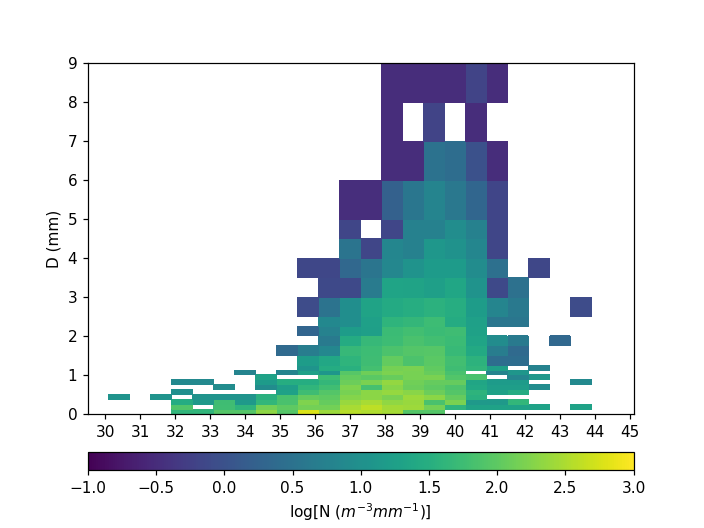

In [90]:
Nc_bin2 = N.empty((N.size(N0r), N.size(D[:Dmax_index+1])))
# Now plot the sampled distribution

Nc_bin_tmp2 = N.zeros((N.size(N0r), N.size(D[:Dmax_index+1])))
Nc_bin2 = N.zeros((N.size(N.array(sampling_times)), N.size(D[:Dmax_index+1])))


# Special treatment for first sampling time. Just assume DSD valid at that time was constant for the previous 
# sampling interval
sample_dict = create_random_gamma_DSD(ntr[0], lamdar[0], 
                                          alphar[0], Vtr, sampling_length, 
                                          sampling_width, Dl, D, Dr, sampling_interval=sampling_interval)
ND_sample = sample_dict['ND']
Nc_bin_tmp2[0, :] = 1.e-3*ND_sample
Nc_bin2[0, :] = Nc_bin_tmp2[0, :]

for index, _ in N.ndenumerate(N0r[:-1]):
    sample_dict = create_random_gamma_DSD(ntr[index], lamdar[index], 
                                          alphar[index], Vtr, sampling_length, 
                                          sampling_width, Dl, D, Dr, sampling_interval=dt[index])
    ND_sample = sample_dict['ND']
    Nc_bin_tmp2[index, :] = 1.e-3*ND_sample


sample_dict = create_random_gamma_DSD(ntr[0], lamdar[0], 
                                      alphar[0], Vtr, sampling_length, 
                                      sampling_width, Dl, D, Dr, sampling_interval=sampling_interval)
ND_sample = sample_dict['ND']

Nc_bin2[0, :] = 1.e-3*ND_sample

for s, sample_index in enumerate(sample_indices[:-1]):
    sample_index_end = sample_indices[s+1]
    current_sample_indices = slice(sample_index, sample_index_end, None)
    
    Nc_bin2[s+1, :] = N.sum(Nc_bin_tmp2[current_sample_indices, :]*dt[current_sample_indices, None], axis = 0)/sampling_interval
#     print "s = ", s
#     print "sample time (beginning) = ", sampling_times[s]
#     print "sample time (end) = ", sampling_times[s+1]
    #print "Nc_bin_tmp = ", Nc_bin_tmp[current_sample_indices, :], dt[current_sample_indices]
    #print "Nc_bin = ", Nc_bin[s+1, :]

Nc_bin2 = N.ma.masked_invalid(Nc_bin2)
logNc_bin2 = N.log10(Nc_bin2)
logNc_bin2 = N.ma.masked_where(logNc_bin2 <= -1.0,logNc_bin2)
fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
C = ax.pcolor(dis_xlocs/1000.,Dl[:Dmax_index+1]*1000.,logNc_bin2.swapaxes(0,1),vmin=-1.0,vmax=3.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
#ax.set_xlim(30.0, 50.0)
ax.set_ylim(0.0,9.0)
ax.set_ylabel('D (mm)')
cax = divider.append_axes("bottom",size="5%",pad=0.35)
cb = fig.colorbar(C,cax=cax,orientation='horizontal')
cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')
plt.savefig('sampled_modelDSD.png',dpi=300)

<IPython.core.display.Javascript object>


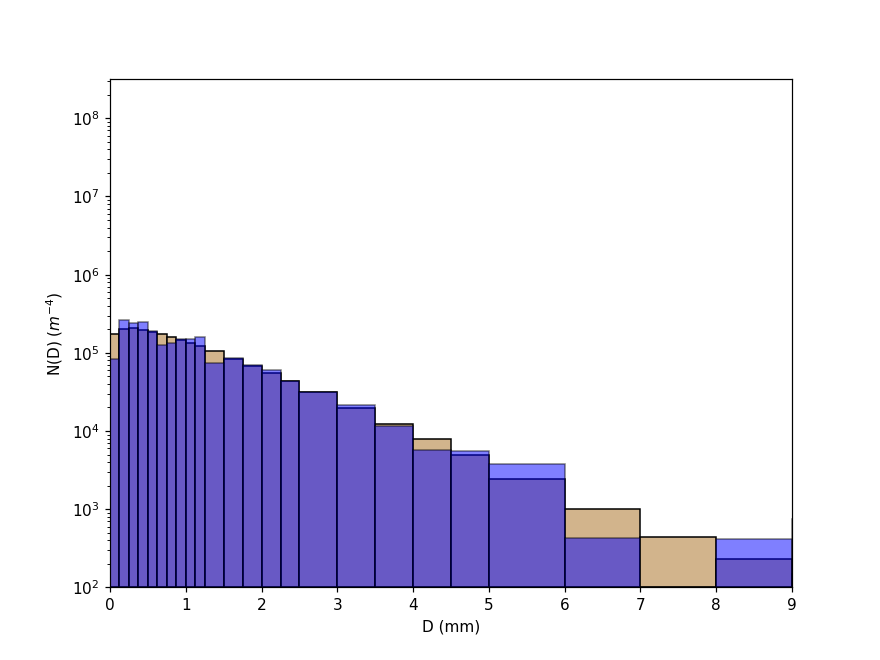

In [91]:
# Plot ND along with sampled ND

ax = plotDSD(Dl*1000., D*1000., Dr*1000., 1000.*Nc_bin[10,:])
ax.bar(Dl[:Dmax_index+1]*1000., 1000.*Nc_bin2[10,:], (Dr-Dl)[:Dmax_index+1]*1000., 10.**2., align='edge', log=True, color='b', edgecolor = 'k', alpha=0.5)
plt.savefig('singleDSD_example.png',dpi=300)

In [ ]:
# Ok, now do the same for one of the ARPS simulations of the 31 March 2016 case:
modelname = 'ARPS'
dirname = '/Volumes/depot/dawson29/data/for_Guo/from_Guo/033116/'
runname = '250mPUR04010000NSSL3MCCN2'
times = [3600.]
microphys = 'ZVD'
jindex = 192
slc = (Ellipsis, slice(None), jindex, slice(None))
jend = 1

dh = getDataHandler(modelname, dirname, times, microphys)
dh.setRun(runname, 0)
xc, yc, zc, zc1d, xe, ye, ze, ze1d, bgmap = dh.loadGrid()

In [ ]:
dh.loadTimes()
time = times[0]
timestring = dh.setTime(time)
dp_data, consts = dh.loadMicrophysics()
dp_data_2D = {}
for key, dat in dp_data.iteritems():
    dp_data_2D[key] = N.asfortranarray(dat[slc].copy())

In [ ]:
cr = N.pi/6.
xindexref = 160
xcplot = (xc[0,jindex,:]-xc[0,jindex,xindexref])/1000.
xeplot = (xe[0,jindex,:]-xc[0,jindex,xindexref])/1000.
N0r,_ = dsd.cal_N0(dp_data_2D['rhoa'],dp_data_2D['qr']/1000.,dp_data_2D['ntr'],
                                       cr,dp_data_2D['alphar'])
lamdar = dsd.cal_lamda(dp_data_2D['rhoa'],dp_data_2D['qr']/1000.,dp_data_2D['ntr'],
                                       cr,dp_data_2D['alphar'])
N0r = N0r[:,0]
lamdar = lamdar[:,0]
tmpalphar2 = dp_data_2D['alphar'][:,0]
Nc_bin = N.empty((N.size(N0r),N.size(D)))

# print N0r
# print lamdar
# print tmpalphar2

print xeplot.shape


for index,dummy in N.ndenumerate(N0r):
    Nc_bin[index,:] = 1.e-3*N0r[index]*(D)**tmpalphar2[index]*N.exp(-lamdar[index]*(D))
Nc_bin = N.ma.masked_invalid(Nc_bin)
logNc_bin = N.log10(Nc_bin)
logNc_bin = N.ma.masked_where(logNc_bin <= -1.0,logNc_bin)
fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
C = ax.pcolor(xeplot,Dl*1000.,logNc_bin.swapaxes(0,1),vmin=-1.0,vmax=3.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.set_xlim(-30.0,30.0)
ax.set_ylim(0.0,9.0)
ax.set_ylabel('D (mm)')
cax = divider.append_axes("bottom",size="5%",pad=0.35)
cb = fig.colorbar(C,cax=cax,orientation='horizontal')
cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')

plt.savefig('raw_modelDSD.png',dpi=300)

In [ ]:
Nc_bin2 = N.empty((N.size(N0r),N.size(D[:Dmax_index+1])))
# Now plot the sampled distribution
for index,_ in N.ndenumerate(N0r):
    # print index,dp_data_2D['ntr'][index,0]
    positions, diameters, velocities, ND_sample = create_random_gamma_DSD(dp_data_2D['ntr'][index,0], lamdar[index], 
                                                                          tmpalphar2[index], Vtr, sampling_length, 
                                                                          sampling_width, Dl, D, Dr, sampling_interval=60.)
    Nc_bin2[index,:] = 1.e-3*ND_sample

Nc_bin2 = N.ma.masked_invalid(Nc_bin2)
logNc_bin2 = N.log10(Nc_bin2)
logNc_bin2 = N.ma.masked_where(logNc_bin2 <= -1.0,logNc_bin2)
fig = plt.figure()
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
C = ax.pcolor(xeplot,Dl[:Dmax_index+1]*1000.,logNc_bin2.swapaxes(0,1),vmin=-1.0,vmax=3.0)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.set_xlim(-30.0,30.0)
ax.set_ylim(0.0,9.0)
ax.set_ylabel('D (mm)')
cax = divider.append_axes("bottom",size="5%",pad=0.35)
cb = fig.colorbar(C,cax=cax,orientation='horizontal')
cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')
plt.savefig('sampled_modelDSD.png',dpi=300)